# Introduction

[Berkeley Earth](http://berkeleyearth.org/data/) has datasets of temperatures recorded from as early as 1750 to 2013. The reported temperatures are averaged from measurements made at a large collection of weather monitoring stations. 

We will be looking at the air temperatures in California from 1950 to 2013 to examine trends, such as rises in temperatures over time from climate change. We choose to study California because we noticed that this state had [the greatest number of acres burned from human-caused wildfires](https://github.com/fredy737/data-science/blob/master/Wildfire%20Prevention%20-%20Learning%20From%20the%20Past/Part%201%20-%20Wildfire%20Prevention%20-%20Learning%20From%20the%20Past.ipynb), and that these fires occurred during warm fire seasons. 

We will aim to predict temperatures in California with time series forecasting, and will with to eventually combine this temperature dataset with the database of wildfires in the United States.

# Reading the Data
We will begin by importing a few of the required libraries for our analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

We will be reading from texts file containing high, average, and low air temperatures from 1870 to 2013 in California. The temperatures are reported as anomalies relative to the temperature average from January 1951 to December 1980. These averages have been recorded in the text file. The latest measurement was made in September 2013, and the analysis was performed in October 2013. 

We will be adding the averages with the anomalies to get the monthly high, low, and average air temperatures in California. For reference, we can also keep track of the errors, or uncertainties, in the temperature measurements. 

In [2]:
# Monthly temperature = averages for months + anomalies
def sum_month_temperature(row, monthly):
    return row['monthly_anomaly'] + monthly.loc[monthly['month'] == row['month'], 'average']

# Propagation of error according to addition performed in sum_month_temperature
def propagate_month_error(row, monthly):
    return (row['monthly_anomaly_unc'] ** 2 + monthly.loc[monthly['month'] == row['month'], 'error'] ** 2) ** .5

# Read from text files, convert to DataFrames. Get monthly temperatures and errors.
def process_time_series(filename):
    # Read the text file with data to read the temperature averages (reported in Celsius)
    f = open(filename, 'r')

    for i in range(49):
        f.readline()    # Skip to where the average temperatures are written

    # Read line with average annual temperature and error in measurement
    line = f.readline()
    split_line = line.split()
    annual_average, annual_average_error = [float(split_line[-3]), float(split_line[-1])]

    for i in range(3):
        f.readline()

    # Read line with average monthly temperatures, write into a DataFrame
    line = f.readline()
    split_line = line.split()

    monthly_temperatures = pd.DataFrame()
    monthly_temperatures['month'] = range(1,13)

    monthly_temperatures['average'] = split_line[1:]
    monthly_temperatures['average'] = monthly_temperatures['average'].astype('float')

    # Read line with errors in average monthly temperatures, write into a DataFrame
    line = f.readline()
    split_line = line.split()

    monthly_temperatures['error'] = split_line[2:]
    monthly_temperatures['error'] = monthly_temperatures['error'].astype('float')

    f.close()

    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y %m')

    # Data starts 69 lines into the text file
    temperature_data = pd.read_table(filename, delim_whitespace=True, skiprows = 69,
                                     names = ['year', 'month', 'monthly_anomaly', 'monthly_anomaly_unc',
                                              'annual_anomaly', 'annual_anomaly_unc', 'five_year_anomaly',
                                              'five_year_anomaly_unc', 'ten_year_anomaly', 'ten_year_anomaly_unc',
                                              'twenty_year_anomaly', 'twenty_year_anomaly_unc'])
    
    # Look at years 1950 to 2013
    temperature_data = temperature_data[temperature_data['year'] > 1949]
    temperature_data.reset_index(inplace = True)

    # Combine year and month into a datetime. Set it so the first day of each month is a timestamp for each month.

    # Add in a day column
    temperature_data['day'] = np.ones(len(temperature_data))

    temperature_data['date'] = pd.to_datetime(temperature_data[['year', 'month', 'day']])

    temperature_data['monthly_temperature'] = np.zeros(len(temperature_data))
    temperature_data['monthly_temperature_error'] = np.zeros(len(temperature_data))

    for index, row in temperature_data.iterrows():
        row['monthly_temperature'] = sum_month_temperature(row, monthly_temperatures)
        row['monthly_temperature_error'] = propagate_month_error(row, monthly_temperatures)
        temperature_data.iloc[index] = row
        
    return temperature_data

Let us apply our functions to create our DataFrames.

In [3]:
# Create time series Pandas objects
high_temperature_data = process_time_series('california-TMAX-Trend.txt')
low_temperature_data = process_time_series('california-TMIN-Trend.txt')
avg_temperature_data = process_time_series('california-TAVG-Trend.txt')

Let us see what the first 13 rows of the avg_temperature_data DataFrame look like.

In [4]:
avg_temperature_data.head(13)

index  year  month  monthly_anomaly  monthly_anomaly_unc  annual_anomaly  \
0    1212  1950      1           -2.488                0.301          -0.068   
1    1213  1950      2            0.383                0.273           0.052   
2    1214  1950      3            0.172                0.199          -0.065   
3    1215  1950      4            1.606                0.230           0.123   
4    1216  1950      5            0.023                0.216           0.083   
5    1217  1950      6           -0.754                0.203           0.401   
6    1218  1950      7            0.358                0.291           0.606   
7    1219  1950      8            0.277                0.310           0.525   
8    1220  1950      9           -0.711                0.141           0.505   
9    1221  1950     10            0.821                0.148           0.452   
10   1222  1950     11            2.323                0.203           0.481   
11   1223  1950     12            2.805                0.276           0.542   
12   1224  1951      1           -0.033                0.367           0.498   

    annual_anomaly_unc  five_year_anomaly  five_year_anomaly_unc  \
0                0.133             -0.369                  0.072   
1                0.142             -0.345                  0.073   
2                0.136             -0.346                  0.072   
3                0.134             -0.310                  0.074   
4                0.134             -0.305                  0.074   
5                0.132             -0.301                  0.075   
6                0.143             -0.284                  0.075   
7                0.136             -0.257                  0.077   
8                0.134             -0.224                  0.075   
9                0.118             -0.215                  0.078   
10               0.104             -0.240                  0.075   
11               0.092             -0.265                  0.075   
12               0.097             -0.234                  0.076   

    ten_year_anomaly  ten_year_anomaly_unc  twenty_year_anomaly  \
0             -0.198                 0.060               -0.046   
1             -0.216                 0.059               -0.052   
2             -0.201                 0.059               -0.052   
3             -0.218                 0.058               -0.054   
4             -0.218                 0.058               -0.064   
5             -0.220                 0.056               -0.062   
6             -0.242                 0.056               -0.054   
7             -0.236                 0.056               -0.057   
8             -0.238                 0.055               -0.047   
9             -0.238                 0.055               -0.050   
10            -0.238                 0.055               -0.050   
11            -0.228                 0.054               -0.058   
12            -0.217                 0.054               -0.059   

    twenty_year_anomaly_unc  day       date  monthly_temperature  \
0                     0.063  1.0 1950-01-01                3.442   
1                     0.062  1.0 1950-02-01                8.413   
2                     0.062  1.0 1950-03-01                9.712   
3                     0.061  1.0 1950-04-01               13.816   
4                     0.061  1.0 1950-05-01               16.273   
5                     0.060  1.0 1950-06-01               19.626   
6                     0.061  1.0 1950-07-01               24.178   
7                     0.062  1.0 1950-08-01               23.457   
8                     0.062  1.0 1950-09-01               19.889   
9                     0.061  1.0 1950-10-01               16.401   
10                    0.061  1.0 1950-11-01               12.323   
11                    0.060  1.0 1950-12-01                9.165   
12                    0.059  1.0 1951-01-01                5.897   

    monthly_temperature_error  
0     

We are going to work with time series of the monthly high, average, and low temperatures. For reference, we will also have separate time series of uncertainties in the temperature measurements.

In [5]:
print('Highs:')
high_temperature_ts = high_temperature_data['monthly_temperature']
high_temperature_ts.index = high_temperature_data['date']
print(high_temperature_ts.head())

high_temperature_error_ts = high_temperature_data['monthly_temperature_error']
high_temperature_error_ts.index = high_temperature_data['date']
print(high_temperature_error_ts.head())

print('Avg:')

avg_temperature_ts = avg_temperature_data['monthly_temperature']
avg_temperature_ts.index = avg_temperature_data['date']
print(avg_temperature_ts.head())

avg_temperature_error_ts = avg_temperature_data['monthly_temperature_error']
avg_temperature_error_ts.index = avg_temperature_data['date']
print(avg_temperature_error_ts.head())

print('Lows:')

low_temperature_ts = low_temperature_data['monthly_temperature']
low_temperature_ts.index = low_temperature_data['date']
print(low_temperature_ts.head())

low_temperature_error_ts = low_temperature_data['monthly_temperature_error']
low_temperature_error_ts.index = low_temperature_data['date']
print(low_temperature_error_ts.head())

Highs:
date
1950-01-01     9.200
1950-02-01    15.359
1950-03-01    16.784
1950-04-01    22.049
1950-05-01    24.809
Name: monthly_temperature, dtype: float64
date
1950-01-01    0.546945
1950-02-01    0.541536
1950-03-01    0.511249
1950-04-01    0.525547
1950-05-01    0.516085
Name: monthly_temperature_error, dtype: float64
Avg:
date
1950-01-01     3.442
1950-02-01     8.413
1950-03-01     9.712
1950-04-01    13.816
1950-05-01    16.273
Name: monthly_temperature, dtype: float64
date
1950-01-01    0.378815
1950-02-01    0.332609
1950-03-01    0.261727
1950-04-01    0.286007
1950-05-01    0.287673
Name: monthly_temperature_error, dtype: float64
Lows:
date
1950-01-01   -2.416
1950-02-01    1.364
1950-03-01    2.656
1950-04-01    5.711
1950-05-01    7.847
Name: monthly_temperature, dtype: float64
date
1950-01-01    0.423968
1950-02-01    0.395479
1950-03-01    0.465536
1950-04-01    0.520419
1950-05-01    0.436688
Name: monthly_temperature_error, dtype: float64


Let us plot the monthly temperatures in California. We will warn the reader beforehand that the following plot will be hard to read, and that they should note the following colors:
- Highs are plotted in orange
- Average temperatures are plotted in green
- Lows are plotted in blue

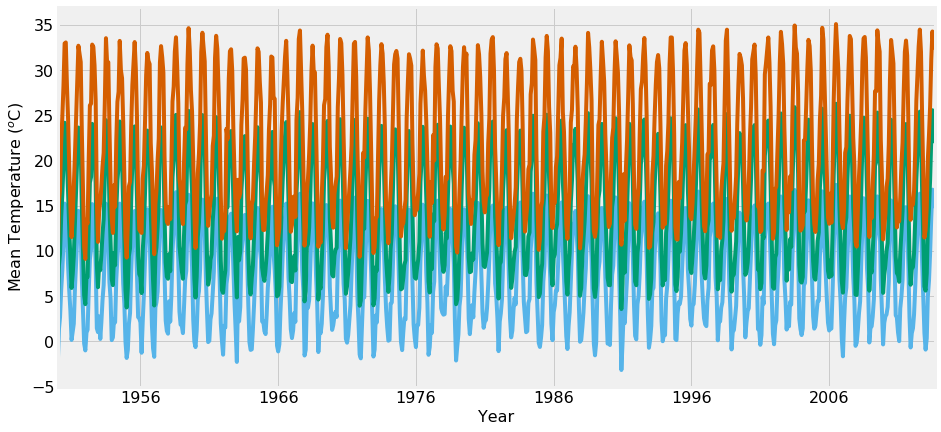

In [6]:
fig = plt.figure(figsize = (14, 7))
plt.plot(low_temperature_ts, color = [86/255,180/255,233/255])
plt.plot(avg_temperature_ts, color = [0,158/255,115/255])
plt.plot(high_temperature_ts, color = [213/255,94/255,0])
plt.tick_params(labelsize = 16)
plt.xlim([datetime.datetime(year = 1950, month = 1, day = 1),
          datetime.datetime(year = 2013, month = 9, day = 1)])
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Mean Temperature ($^o$C)', fontsize = 16);

All we can get from this is that the high temperatures are higher than the average temperatures, which are higher than the low temperatures. This was already inferred from the definitions of those temperature values. Can we make some sense from these time series?

# Time Series Analysis: Breaking Apart and Making Predictions
## Monthly Average Tempeatures

Let's start by focusing on the average temperatures (plotted in green in the previous figure). Let us see if the mean monthly temperatures show stationarity. We will look at rolling statistics (mean and standard deviation) and perform the Dickey-Fuller test.

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistics
    fig = plt.figure(figsize = (12,6))
    orig = plt.plot(timeseries, color = [0,158/255,115/255], label = 'Original')
    mean = plt.plot(rolmean, color = [213/255,94/255,0], label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'k', label = 'Rolling Std')
    plt.legend(loc = 'best', fontsize = 16)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block = False)
    
    # Perform Dickey-Fuller test
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used',
                                               'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

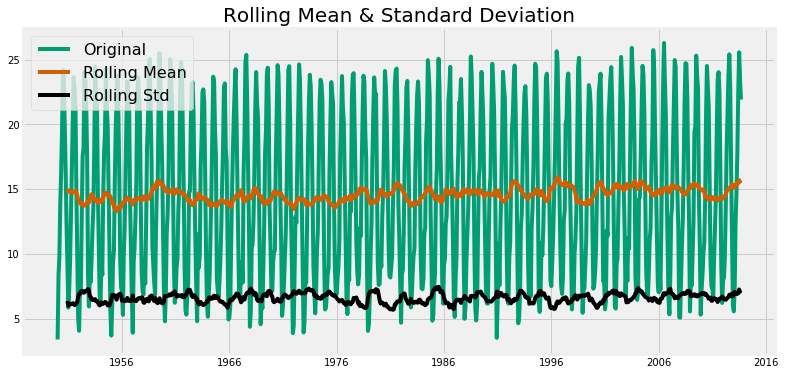

Results of the Dickey-Fuller Test:
Test Statistic                -5.682918e+00
p-value                        8.405686e-07
#Lags Used                     1.800000e+01
Number of Observations Used    7.460000e+02
Critical Value (1%)           -3.439146e+00
Critical Value (5%)           -2.865422e+00
Critical Value (10%)          -2.568837e+00
dtype: float64


In [8]:
test_stationarity(avg_temperature_ts)

The Dickey-Fuller test statistic is lower than the critical value at 1%. What this means is that we can say with 99% confidence that the time series is stationary, based on the rolling average. Does that imply there is no noticeable change in temperature, and that increases in temperature are just attributed to randomness (i.e. randomness within a random walk)? We will be addressing that shortly. We should note that there is still some variation in the rolling average, with a very slight increase over the 60 years in this time series.

If we wish to do forecasting with this time series, we will still need to take into account its periodic nature. Let extract the trends and seasonality from 1950 to 2013 with seasonal decomposition. For this decomposition, let us set the frequency to 12, as there are 12 months in a year.

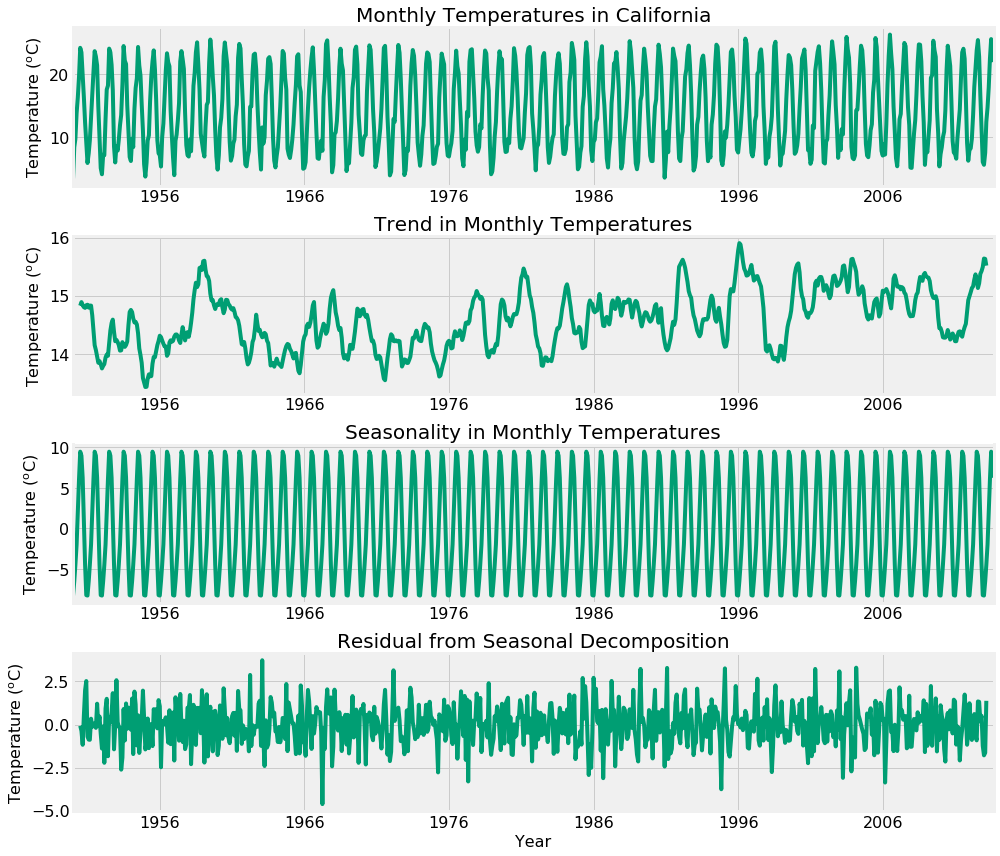

In [9]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition. Frequency is 12, corresponding to 12 months in a year
rcParams['figure.figsize'] = 18, 8
decomposition_avg = seasonal_decompose(avg_temperature_ts, freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(avg_temperature_ts, color = [0,158/255,115/255])
ax1.set_title('Monthly Temperatures in California', fontsize = 20)
ax2.plot(decomposition_avg.trend, color = [0,158/255,115/255])
ax2.set_title('Trend in Monthly Temperatures', fontsize = 20)
ax3.plot(decomposition_avg.seasonal, color = [0,158/255,115/255])
ax3.set_title('Seasonality in Monthly Temperatures', fontsize = 20)
ax4.plot(decomposition_avg.resid, color = [0,158/255,115/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 1950, month = 1, day = 1), 
              datetime.datetime(year = 2013, month = 9, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

Our previous analysis with the Dickey-Fulley test told us that the mean temperature time series is stationary. However, if we look at the trend, we notice that there is a slight increase in mean temperatures by about half a degree Celsius temperature starting from around the late 1970s. This increase [can have major consequences](https://climate.nasa.gov/news/2458/why-a-half-degree-temperature-rise-is-a-big-deal/). 

We see that our temperature data has very apparent seasonality: The seasonality oscillates between just under -7.5 degrees Celsius to 10 degrees Celsius every year, corresponding to the temperature changes throughout the four seasons of the year. We can see this more clearly if we zoom in on the seasonality graph.

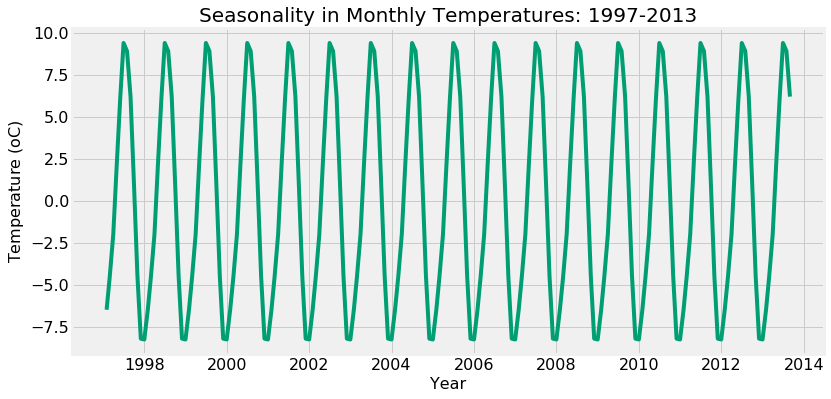

In [10]:
fig = plt.figure(figsize = (12, 6))
plt.plot(decomposition_avg.seasonal[-200:], color = [0,158/255,115/255])
plt.tick_params(labelsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($\mathrm{o}$C)', fontsize = 16)
plt.title('Seasonality in Monthly Temperatures: 1997-2013', fontsize = 20);

We notice that our trend and residual are still periodic. While our seasonality frequency is based on the fact that temperatures are cyclic every 12 months, what if we increase the width of the cycles in the seasonality? Let us change the frequency to 10 years, so 120 months, and see what changes.

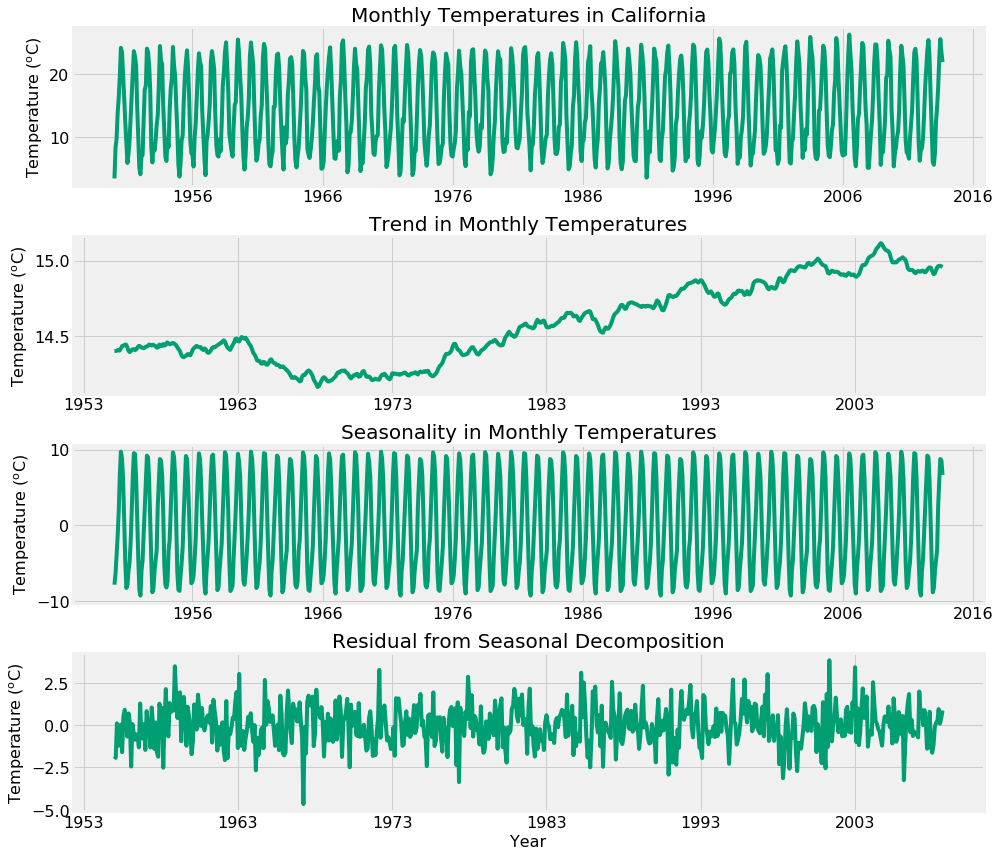

In [11]:
from pylab import rcParams
import statsmodels.tsa.seasonal as season

# Perform seasonal decomposition with a frequency of 120
rcParams['figure.figsize'] = 18, 8
decomposition_avg_10 = season.seasonal_decompose(avg_temperature_ts, freq = 12*10)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(avg_temperature_ts, color = [0,158/255,115/255])
ax1.set_title('Monthly Temperatures in California', fontsize = 20)
ax2.plot(decomposition_avg_10.trend, color = [0,158/255,115/255])
ax2.set_title('Trend in Monthly Temperatures', fontsize = 20)
ax3.plot(decomposition_avg_10.seasonal, color = [0,158/255,115/255])
ax3.set_title('Seasonality in Monthly Temperatures', fontsize = 20)
ax4.plot(decomposition_avg_10.resid, color = [0,158/255,115/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

The increase in the average temperature by 0.50-0.75 degrees Celsius in California is seen more clearly in the trend if we decomposed the temperature time series by treating 10 years as a period in the seasonality. This clarity is nice to see, but we should stick to treating 12 months as a period in the seasonality. 

What if we can predict the average temperature in California beyond this time series? This may be an interesting exercise, considering the most recent measurement in this dataset was made in September 2013. If we wish to do forecasting, we can check the forecasting against temperatures reported from 2014 to 2018. This extrapolation will include the year 2017, which has been widely reported to be the [hottest](http://www.latimes.com/science/sciencenow/la-sci-sn-global-temperatures-2017-20180118-story.html) [year](https://www.kqed.org/science/1859207/so-far-2017-is-2nd-hottest-year-on-record) [on record](https://www.theguardian.com/environment/climate-consensus-97-per-cent/2018/jan/02/2017-was-the-hottest-year-on-record-without-an-el-nino-thanks-to-global-warming). In particular, California has had some of its hottest summers [in 2017](https://www.mercurynews.com/2017/09/01/new-data-california-is-having-its-hottest-summer-ever/) [and 2018](https://phys.org/news/2018-08-california-fluke-experts.html).

We wish to employ the SARIMA model (seasonal ARIMA), which requires us to determine parameters. In order to do so, let us examine a stationary form of our temperature time series. The seasonality in the time series works against the time series's stationarity. So, let's take a seasonal difference.

Text(0.5,1,'Seasonal Differenced Temperatures in California')

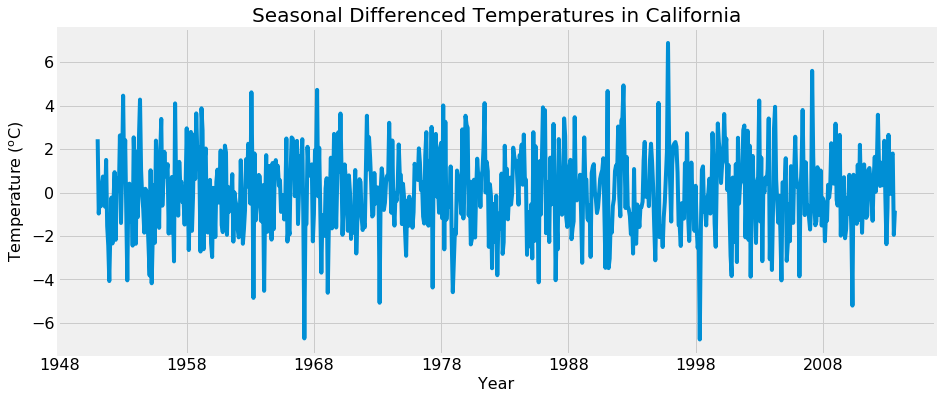

In [12]:
# Seasonal difference: First difference after shifting by 12 months (a year)
avg_temperature_seasonal_diff = avg_temperature_ts - avg_temperature_ts.shift(12)

fig = plt.figure(figsize = (14, 6))
plt.plot(avg_temperature_seasonal_diff)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.title('Seasonal Differenced Temperatures in California', fontsize = 20)

Let us examine the stationarity of this seasonal differenced time series.

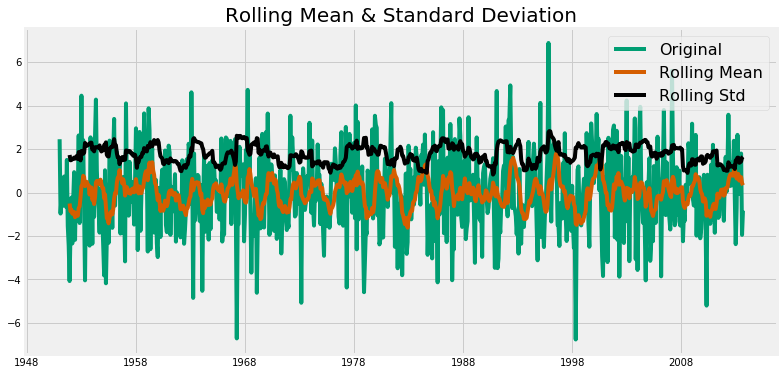

Results of the Dickey-Fuller Test:
Test Statistic                -1.452563e+01
p-value                        5.434517e-27
#Lags Used                     1.100000e+01
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [13]:
test_stationarity(avg_temperature_seasonal_diff[12:])

The p-value in the Dickey-Fuller test is significantly lower than when we did the Dickey-Fuller test on the original temperature time series. Taking the seasonal difference has reduced the periodicity of the time series, which looks more like the residual from when we performed the seasonal decomposition earlier.

We can take a first difference of this new time series to further improve its stationarity, and this can decrease the amplitudes of the oscillations of the rolling mean in the above average. 

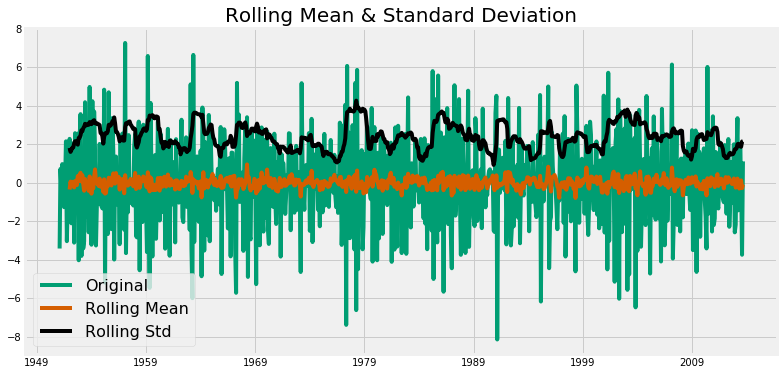

Results of the Dickey-Fuller Test:
Test Statistic                -1.211737e+01
p-value                        1.859038e-22
#Lags Used                     2.000000e+01
Number of Observations Used    7.310000e+02
Critical Value (1%)           -3.439327e+00
Critical Value (5%)           -2.865502e+00
Critical Value (10%)          -2.568880e+00
dtype: float64


In [15]:
first_diff_seasonal_diff = avg_temperature_seasonal_diff - avg_temperature_seasonal_diff.shift(1)
test_stationarity(first_diff_seasonal_diff[13:])

The rolling mean is more stationary/constant than it was when we only took a seasonal difference of the temperature time series. Let us look at the autocorrelation and partial autocorrelation functions of this time series.

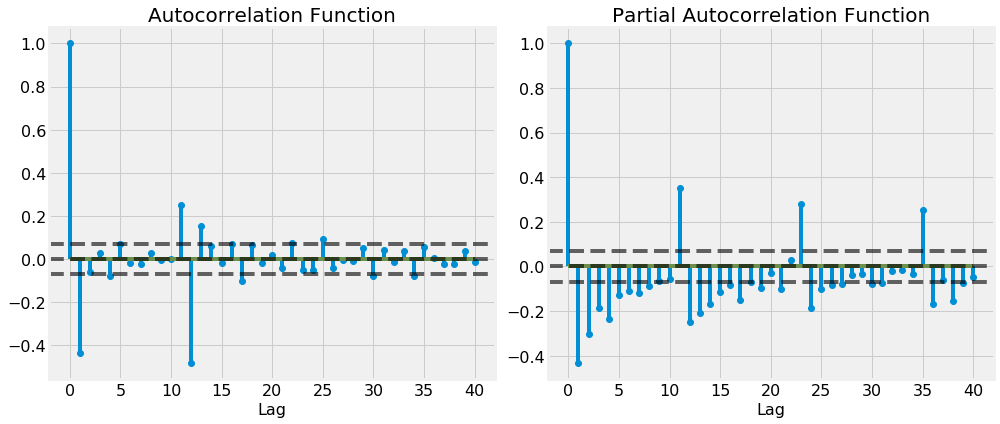

In [16]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate autocorrelation and partial autocorrelation functions of the temperatuer time series
# after performing seasonal difference with lags up to 40
# First 12 entries are missing
lag_acf = acf(first_diff_seasonal_diff[13:], nlags = 40)
lag_pacf = pacf(first_diff_seasonal_diff[13:], nlags = 40)

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.stem(lag_acf)
ax1.axhline(0, ls = 'dashed', color = 'k', alpha = .6)
# Plot lower and upper confidence levels
ax1.axhline(-1.96 / np.sqrt(len(first_diff_seasonal_diff)), ls = 'dashed', color = 'k', alpha = .6)    # Confidence intervals
ax1.axhline(1.96 / np.sqrt(len(first_diff_seasonal_diff)), ls = 'dashed', color = 'k', alpha = .6)    # Confidence intervals
ax1.set_title('Autocorrelation Function', fontsize = 20)
ax1.set_xlabel('Lag', fontsize = 16)
ax1.tick_params(labelsize = 16)

ax2.stem(lag_pacf)
ax2.axhline(0, ls = 'dashed', color = 'k', alpha = .6)
# Plot lower and upper confidence levels
ax2.axhline(-1.96 / np.sqrt(len(first_diff_seasonal_diff)), ls = 'dashed', color = 'k', alpha = .6)    # Confidence intervals
ax2.axhline(1.96 / np.sqrt(len(first_diff_seasonal_diff)), ls = 'dashed', color = 'k', alpha = .6)    # Confidence intervals
ax2.set_title('Partial Autocorrelation Function', fontsize = 20)
ax2.set_xlabel('Lag', fontsize = 16)
ax2.tick_params(labelsize = 16)

fig.tight_layout()

The SARIMA model requires seven parameters: (p,d,q)(P,D,Q)s. These parameters determine the functional form of our prediction model equation.

We see that both autocorrelation functions are negative and have magnitudes greater than a confidence interval at lag 12, which corresponds to the seaonality frequency.

It's likely that the parameters p and q may be both 1, as both autocorrelation functions cross the confidence interval at lag 1. That said, let us also determine our parameters (p,d,q)(P,D,Q) through a grid search.

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


We will select our parameters (p,d,q)(P,D,Q) that give us the lowest Akaike information criterion (AIC) from the SARIMA model.

In [18]:
min_aic = 1e8

# Iterate through the (p,d,q)(P,D,Q) parameters. Calculate the AIC for each model
# Print output only if (p,d,q)(P,D,Q) returns lower AIC values
# Final output corresponds to the mininmum AIC
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(avg_temperature_ts,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < min_aic:
                min_aic = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6402.350204564532
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5450.0897663450305
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:4762.5690061311525
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3049.2774136283006
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2522.79408138059
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:2482.1050662938733
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:2479.6218344748722
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:2465.033583714053
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:2462.2150363914807
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:2460.9421970259045
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:2459.2467165436965
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:2456.6173359852273
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:2453.7814607579376
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:2452.9052582008617


Our parameters for the SARIMA model are: (1,1,2)(1,1,2,12)12. The d and D parameters are 1 each. We will be fitting a SARIMA model to the first difference of the seasonal difference of the time series. Now that we know the functional form of the SARIMA model, let us fit this model to our temperature time series.

In [18]:
# Fit SARIMA model to avg_temperature_ts
model_avg = SARIMAX(avg_temperature_ts,
                    order=(1, 1, 2),
                    seasonal_order=(1, 1, 2, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

results_avg = model_avg.fit()

print(results_avg.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                monthly_temperature   No. Observations:                  765
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1219.453
Date:                            Thu, 08 Nov 2018   AIC                           2452.905
Time:                                    01:26:20   BIC                           2485.008
Sample:                                01-01-1950   HQIC                          2465.295
                                     - 09-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4024      0.209      1.928      0.054      -0.007       0.811
ma.L1         -1.2569      0.220   

If we look at the covariance table, we notice that three of our coefficients have p-values that are not lower than or close to 0.05. This implies that three of the coefficients are not statistically significant.

That set, let us run model diagnostics and see if there is any unusual behavior in our SARIMA model.

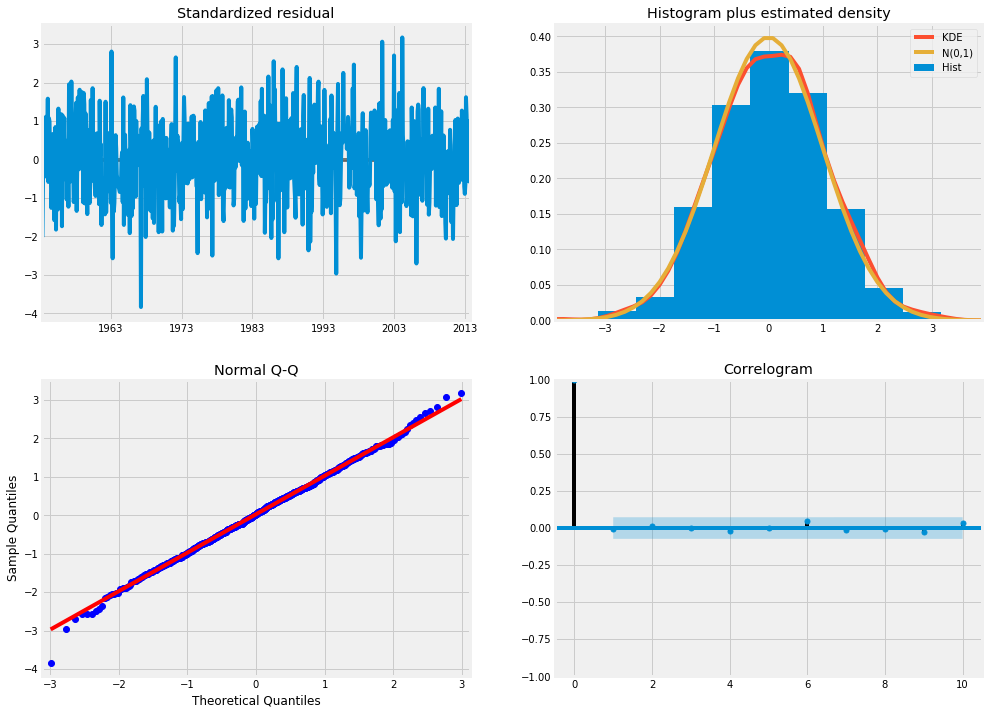

In [17]:
results_avg.plot_diagnostics(figsize=(15, 12))
plt.show()

What we wish to confirm is that our residuals (top-left) are uncorrelated and normally distributed with zero-mean. We see that:
- In the top right figure, the distribution (and KDE) of the residual values is close to a normal distribution with a mean of 0 and a standard deviation of 1, indicating that our residuals are normally distributed.
- The Q-Q plot (bottom left) shows that the ordered distribution of residuals (blue dots) closely follows the linear trend of the samples taken from a normal distribution (red). This again indicates that our residuals are normally distributed.
- The autocorrelation plot in the bottom right shows that the time series residuals have low correlation with lagged versions of itself. This is indicated by the low values in the autocorrelation function.

Now that we have trained a model on our time series, let us see how well this model predicts temperatures. Let us test by reproducing the time series for the last five years in the temperature dataset.

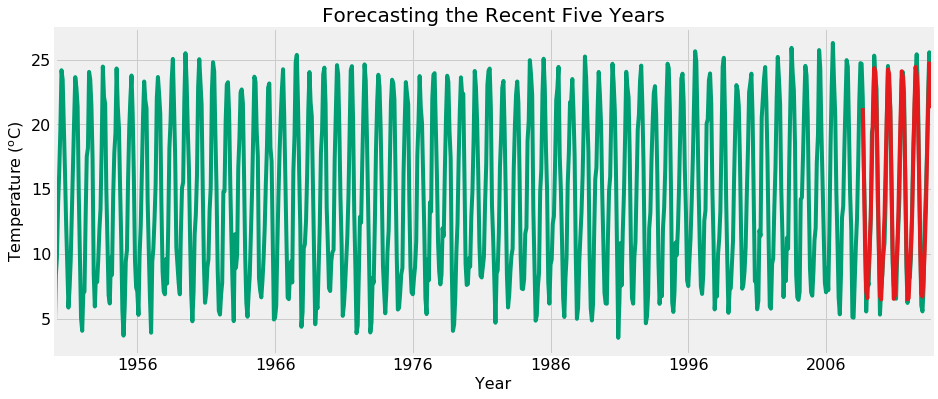

In [18]:
fig = plt.figure(figsize = (14, 6))
plt.plot(avg_temperature_ts, color = [0,158/255,115/255])

# Plot a forecasted time series from the SARIMA model from 2008 to 2013
plt.plot(results_avg.predict(start = 704, end = 764, dynamics = True), color = [228/255,26/255,28/255])
plt.title('Forecasting the Recent Five Years', fontsize = 20)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xlim([datetime.datetime(year = 1950, month = 1, day = 1),
          datetime.datetime(year = 2013, month = 9, day = 1)]);

We see that our SARIMA model does a good job at reproducing the monthly temperatures from 2008 to 2013. Let us see how well the SARIMA model forecasts the monthly temperatures in California beyond 2013.

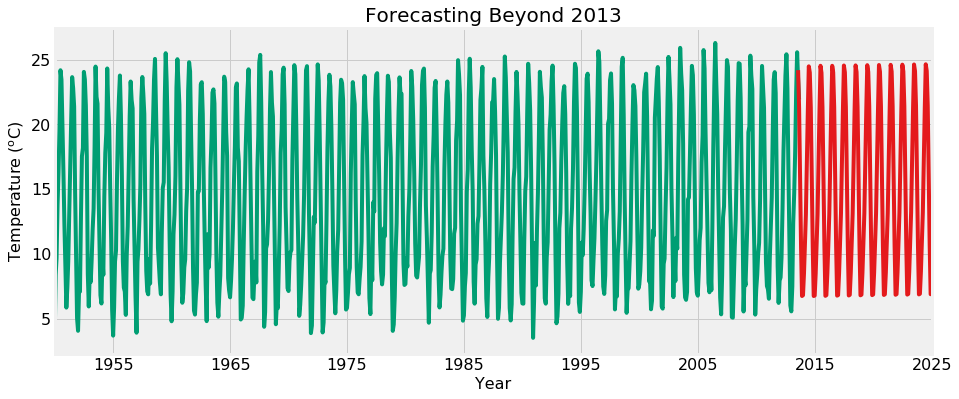

In [19]:
fig = plt.figure(figsize = (14, 6))
plt.plot(avg_temperature_ts, color = [0,158/255,115/255])
plt.title('Forecasting Beyond 2013', fontsize = 20)

# Plot a forecasted time series from the SARIMA model from the end of 2013 to 2024
plt.plot(results_avg.predict(start = 763, end = 900, dynamics = True), color = [228/255,26/255,28/255])
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xlim([datetime.datetime(year = 1950, month = 1, day = 1),
          datetime.datetime(year = 2025, month = 1, day = 1)]);

We note that the forecasted series (red) does not capture the noise in the original temperature data. The minima and maxima of the forecasted series seem to be oscillating under a seemingly constant amplitude. However, the forecasted monthly temperatures from the SARIMA model capture the seasonality, and we see a slight increase in temperature with time. Let us do a seasonal decomposition of the forecasted temperature time series.

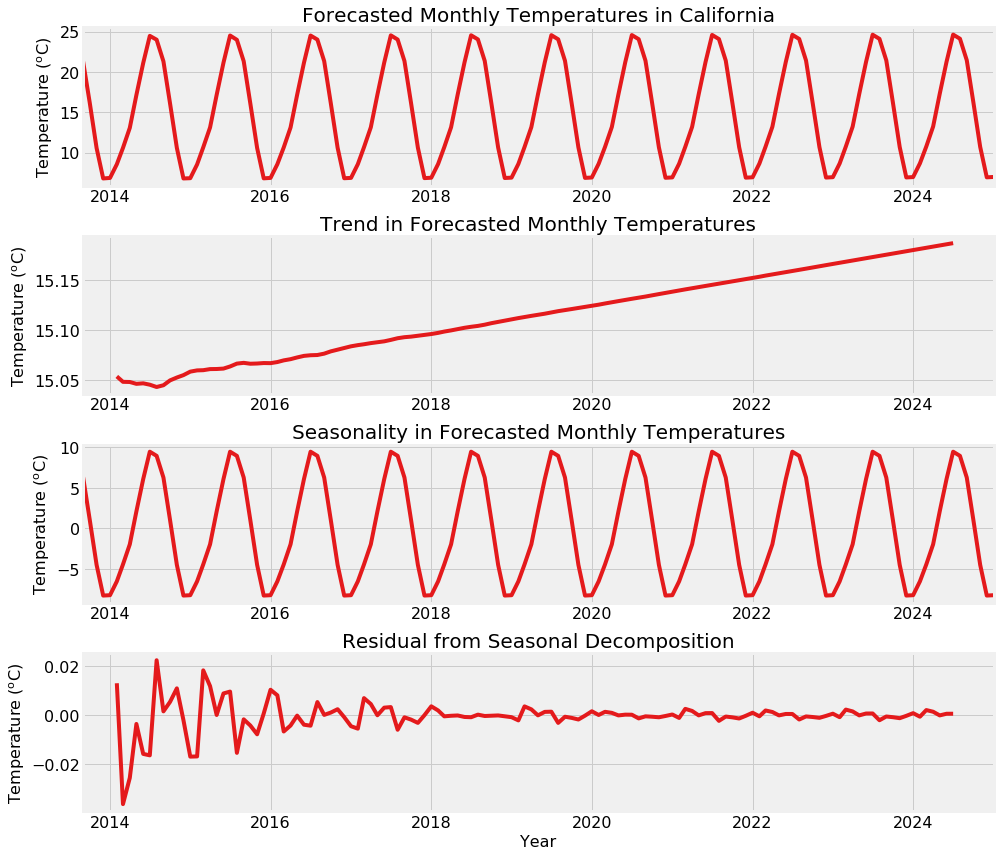

In [19]:
rcParams['figure.figsize'] = 18, 8
# Perform seasonal decomposition on the forecasted temperature time series
decomposition_avg = seasonal_decompose(results_avg.predict(start = 763, end = 900, dynamics = True), freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(results_avg.predict(start = 763, end = 900, dynamics = True), color = [228/255,26/255,28/255])
ax1.set_title('Forecasted Monthly Temperatures in California', fontsize = 20)
ax2.plot(decomposition_avg.trend, color = [228/255,26/255,28/255])
ax2.set_title('Trend in Forecasted Monthly Temperatures', fontsize = 20)
ax3.plot(decomposition_avg.seasonal, color = [228/255,26/255,28/255])
ax3.set_title('Seasonality in Forecasted Monthly Temperatures', fontsize = 20)
ax4.plot(decomposition_avg.resid, color = [228/255,26/255,28/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 2013, month = 9, day = 1), 
              datetime.datetime(year = 2025, month = 1, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

We see that the average of the forecasted mean monthly temperatures increases by almost 0.15 degree Celsius from 2014 to 2024. 

How accurate is this forecasting? We cannot evaluate the predictions for 2019 to 2025, but we *have* data from the end of 2013 to the present day (the latest month available is September 2018).

While this data is not pulled from the Berkeley Earth project, we were able to obtain a time series from the [National Oceanic and Atmospheric Administration (NOAA)](https://www.noaa.gov/), which can give us near-real time statewide temperature measurements. It is noted that more recent values reported in the NOAA time series may need further quality control to account for factors such as instrument changes, station relocation, observer practice changes, and urbanization. 

Let us load the time series from the NOAA into this project.

In [21]:
# Read csv file from NOAA
noaa_temperature = pd.read_csv('4-tavg-all-10-2013-2018.csv', skiprows = 4)
noaa_temperature.head()

Date  Value  Anomaly
0  201301   42.1     -0.2
1  201302   45.3      0.0
2  201303   53.8      5.0
3  201304   58.2      4.2
4  201305   63.8      3.1

We're going to need to convert this DataFrame into a time series. This will involve transforming the Date column into a column with datetime objects. We also need to convert the temperature readings in the Value column from Fahrenheit to Celsius.

In [22]:
# Add a Temperature column with temperatures in Celsius
noaa_temperature['Temperature'] = 5 / 9. * (noaa_temperature['Value'] - 32)

# Convert the integers in the Date column into datetime objects 
noaa_temperature['datetime'] = noaa_temperature['Date'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m'))

# Create a new time series starting from October 2013
noaa_temperature_october = noaa_temperature[noaa_temperature['datetime'] > datetime.datetime(year = 2013, 
                                                                                             month = 9, day = 1)]
noaa_temperature_ts = noaa_temperature_october['Temperature']
noaa_temperature_ts.index = noaa_temperature_october['datetime']
noaa_temperature_ts.head()

datetime
2013-10-01    14.722222
2013-11-01    11.055556
2013-12-01     6.722222
2014-01-01    10.055556
2014-02-01     9.888889
Name: Temperature, dtype: float64

Let us compare the forecasted monthly temperatures with the actual monthly temperatures in California from October 2013 to September 2018.

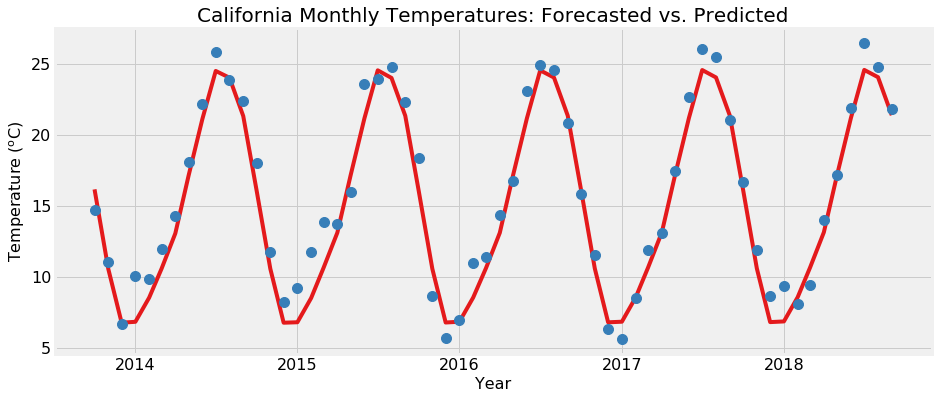

In [23]:
fig = plt.figure(figsize = (14,6))
plt.plot(results_avg.predict(start = 765, end = 824, dynamics = True), color = [228/255,26/255,28/255])
plt.plot(noaa_temperature_ts, 'o', color = [55/255,126/255,184/255], markersize = 10)
plt.title('California Monthly Temperatures: Forecasted vs. Predicted', fontsize = 20)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)

We note that the forecasted and actual monthly temperatures are close in value. However, the forecasted time series does not capture the rise in temperatures in the summer months of 2017 and 2018.

Let us look at the root mean squared error between the forecasted and predicted monthly temperatures.

In [24]:
# Forecasted time series from October 2013 to September 2018
forecasted = results_avg.predict(start = 765, end = 824, dynamics = True)

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(noaa_temperature_ts, forecasted))

1.398929699327893

The forecasted prediction adequately captures the periodic trends in the monthly temperatures. We have a root mean squared error of roughly 1.40 degrees Celsius.

What if we append this NOAA data to our original temperature time series?

In [25]:
# Combine the two time series with monhtly average temperatures in California
combined_temperature_ts = avg_temperature_ts.combine_first(noaa_temperature_ts)
print('First five months in the time series:')
print(combined_temperature_ts.head())
print('Last five months in the time series:')
print(combined_temperature_ts.tail())

First five months in the time series:
1950-01-01     3.442
1950-02-01     8.413
1950-03-01     9.712
1950-04-01    13.816
1950-05-01    16.273
Name: monthly_temperature, dtype: float64
Last five months in the time series:
2018-05-01    17.166667
2018-06-01    21.888889
2018-07-01    26.444444
2018-08-01    24.722222
2018-09-01    21.833333
Name: monthly_temperature, dtype: float64


Let us look at the stationarity of this new time series.

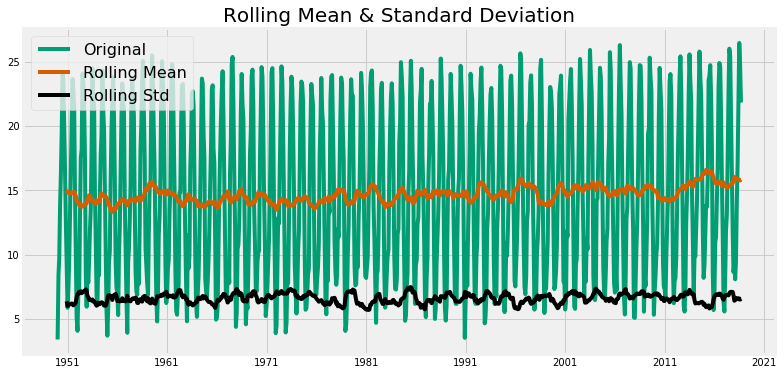

Results of the Dickey-Fuller Test:
Test Statistic                  -4.203718
p-value                          0.000649
#Lags Used                      21.000000
Number of Observations Used    803.000000
Critical Value (1%)             -3.438520
Critical Value (5%)             -2.865146
Critical Value (10%)            -2.568690
dtype: float64


In [26]:
test_stationarity(combined_temperature_ts)

We can still say with 99% confidence that the new time series is stationary, but we note that the p-value is greater than the p-value from the Dickey-Fuller test on our original average temperature time series. This most likely arises from the rise in temperatures from 2013 to 2018.

Let us do seasonal decomposition on the combined time series.

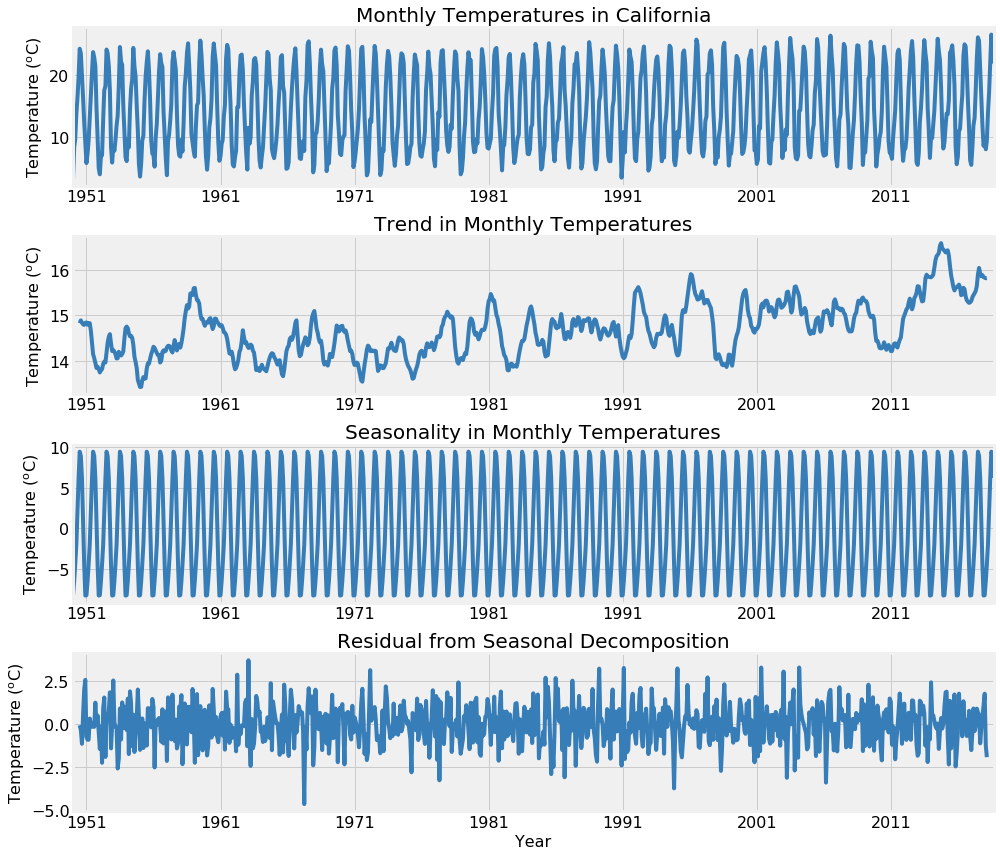

In [27]:
# Perform seasonal decomposition with a frequency of 120
rcParams['figure.figsize'] = 18, 8
decomposition_avg_2018 = season.seasonal_decompose(combined_temperature_ts, freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(combined_temperature_ts, color = [55/255,126/255,184/255])
ax1.set_title('Monthly Temperatures in California', fontsize = 20)
ax2.plot(decomposition_avg_2018.trend, color = [55/255,126/255,184/255])
ax2.set_title('Trend in Monthly Temperatures', fontsize = 20)
ax3.plot(decomposition_avg_2018.seasonal, color = [55/255,126/255,184/255])
ax3.set_title('Seasonality in Monthly Temperatures', fontsize = 20)
ax4.plot(decomposition_avg_2018.resid, color = [55/255,126/255,184/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 1950, month = 1, day = 1), 
              datetime.datetime(year = 2018, month = 9, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

The increase in temperature is more pronounced in the trend in the years past 2013, especially in the years 2017 and 2018.

Let us see if we can train a SARIMA model to this combined temperature dataset, and see if that will improve our predictions for up to 2025.

In [159]:
min_aic = 1e8

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(combined_temperature_ts,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < min_aic:
                min_aic = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6913.459306086533
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5887.645149412374
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:5146.834408818423
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3277.362453015764
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2739.857360659121
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:2700.3417012988402
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:2697.243154925039
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:2676.7498052882734
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:2673.2631866433985
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:2670.468386585585
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:2667.705835216755
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:2666.7626438631814
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:2654.8776643692586
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:2652.0015410810875
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:2650.6855568781


In [28]:
# Fit SARIMA model to combined_temperature_ts
model_combined = SARIMAX(combined_temperature_ts,
                         order=(1, 1, 2),
                         seasonal_order=(1, 1, 2, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

results_combined = model_combined.fit()

print(results_combined.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                monthly_temperature   No. Observations:                  825
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1318.343
Date:                            Thu, 08 Nov 2018   AIC                           2650.686
Time:                                    01:38:35   BIC                           2683.345
Sample:                                01-01-1950   HQIC                          2663.243
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4138      0.195      2.123      0.034       0.032       0.796
ma.L1         -1.2767      0.200   

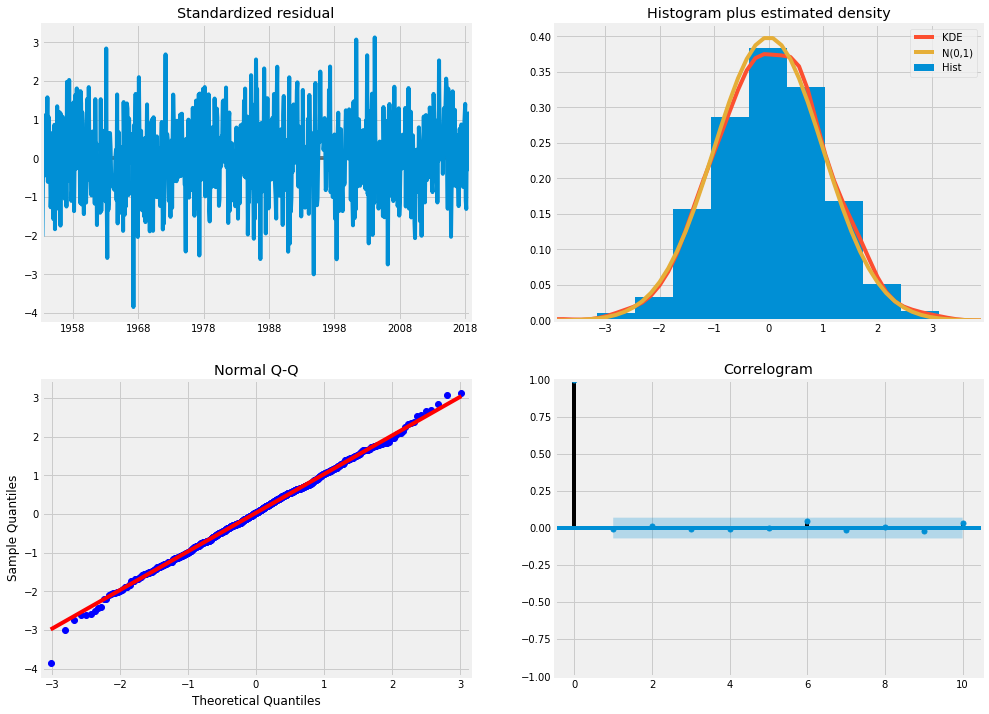

In [29]:
results_combined.plot_diagnostics(figsize=(15, 12))
plt.show()

Some of the MA coefficients may not be statistically significant, but we notice that the residuals are normally distributed around a zero mean and are uncorrelated.

Let us plot forecasts from our new trained SARIMA model and compare with monthly temperatures from 2013 to 2018.

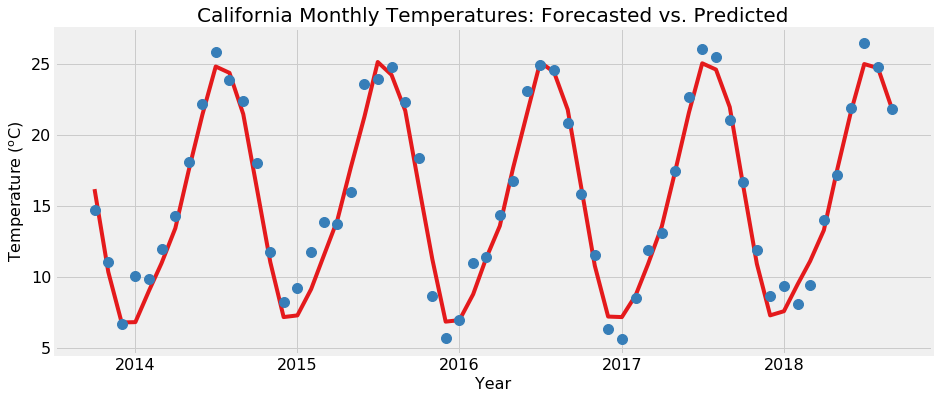

In [30]:
fig = plt.figure(figsize = (14,6))
plt.plot(results_combined.predict(start = 765, end = 824, dynamics = True), color = [228/255,26/255,28/255])
plt.plot(noaa_temperature_ts, 'o', color = [55/255,126/255,184/255], markersize = 10)
plt.title('California Monthly Temperatures: Forecasted vs. Predicted', fontsize = 20)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)

In [31]:
# Forecasted time series from October 2013 to September 2018
forecasted = results_combined.predict(start = 765, end = 824, dynamics = True)
np.sqrt(mean_squared_error(noaa_temperature_ts, forecasted))

1.2447977297292923

The root mean squared error is 1.24 degrees Celsius, slightly better than the RMSE from using the SARIMA model fit to the Berkeley Earth data alone. We note that this SARIMA model was trained on years including 2013 through 2018, and was used to predict temperatures in 2013 to 2018, so the above RMSE is more of an in-sample error rather than an out-of-sample error.

That said, let us see how our new SARIMA model predicts temperatures beyond 2018.

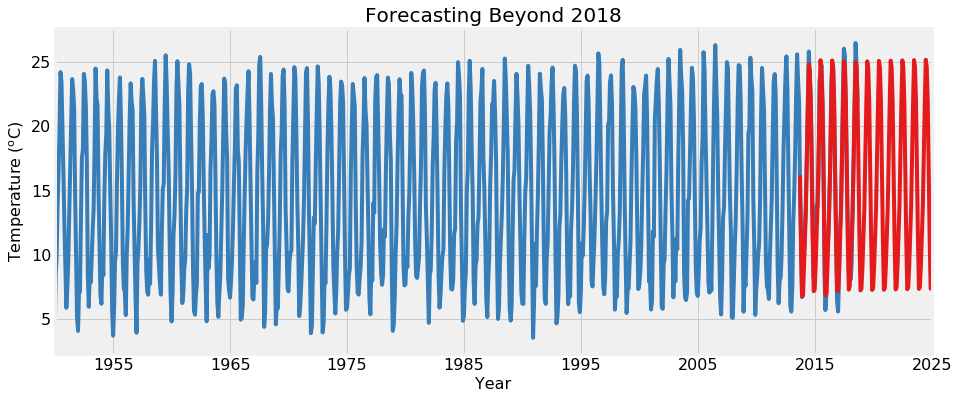

In [32]:
fig = plt.figure(figsize = (14, 6))
plt.plot(combined_temperature_ts, color = [55/255,126/255,184/255])
plt.title('Forecasting Beyond 2018', fontsize = 20)

# Plot a forecasted time series from the SARIMA model from the end of 2013 to 2024
plt.plot(results_combined.predict(start = 765, end = 900, dynamics = True), color = [228/255,26/255,28/255])
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xlim([datetime.datetime(year = 1950, month = 1, day = 1),
          datetime.datetime(year = 2025, month = 1, day = 1)]);

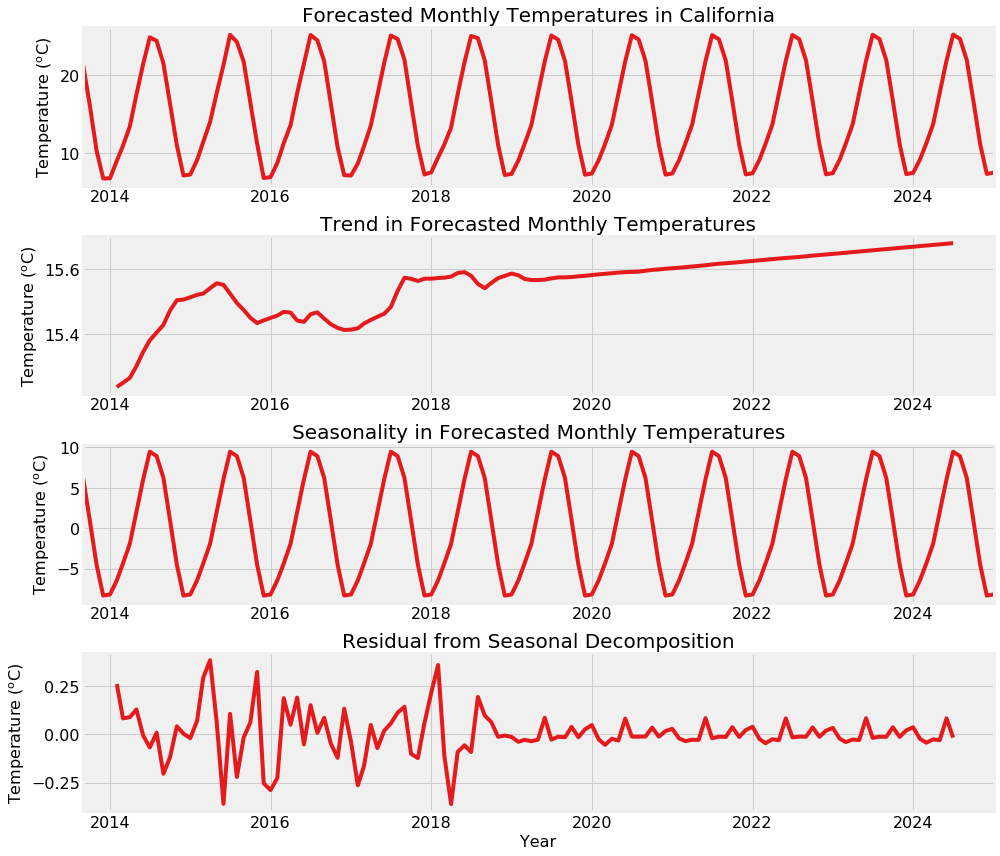

In [33]:
rcParams['figure.figsize'] = 18, 8
# Perform seasonal decomposition on the forecasted temperature time series
decomposition_combined = seasonal_decompose(results_combined.predict(start = 763, end = 900, dynamics = True), freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(results_combined.predict(start = 763, end = 900, dynamics = True), color = [228/255,26/255,28/255])
ax1.set_title('Forecasted Monthly Temperatures in California', fontsize = 20)
ax2.plot(decomposition_combined.trend, color = [228/255,26/255,28/255])
ax2.set_title('Trend in Forecasted Monthly Temperatures', fontsize = 20)
ax3.plot(decomposition_combined.seasonal, color = [228/255,26/255,28/255])
ax3.set_title('Seasonality in Forecasted Monthly Temperatures', fontsize = 20)
ax4.plot(decomposition_combined.resid, color = [228/255,26/255,28/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 2013, month = 9, day = 1), 
              datetime.datetime(year = 2025, month = 1, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

Our new forecast model predicts a steady increase in the average temperatures in California by about 0.1 degree Celsius from 2018 to 2025. What is noted is that the trend from 2014 to 2025 from the new forecast shows an increase of roughly 0.3 degree Celsius, while the trend from 2014 to 2025 from the old forecast showed an increase of roughly 0.1 degree Celsius. Including the most recent temperature data (2013 to 2018) has changed our predictions.

We should not expect the temperature predictions from this time series analysis to be perfect. In particular, the farther we go into the future, the less accurate our predictions will be, as the predictions depend on the noise and trends in the most recent data points in the time series. So it may be more prudent to look at forecasted temperatures up to, for instance, the next year (2019) rather than the next half-decade.

So let's do that. We previously stated that California had some of its hottest summers in the past two years, particularly in July. Let us look at the monthly average temperatures in July 2017 and 2018, and compare it to the value forecasted for July 2019.

In [34]:
forecast_beyond_2018 = results_combined.predict(start = 763, end = 900, dynamics = True)

print('Average July temperature in California in 2017:')
print(noaa_temperature_ts[datetime.datetime(year = 2017, month = 7, day = 1)] * 9/5. + 32)
print('Average July temperature in California in 2018:')
print(noaa_temperature_ts[datetime.datetime(year = 2018, month = 7, day = 1)] * 9/5. + 32)
print('Forecasted average July temperature in California in 2019:')
print(forecast_beyond_2018[datetime.datetime(year = 2019, month = 7, day = 1)] * 9/5. + 32)

Average July temperature in California in 2017:
78.8
Average July temperature in California in 2018:
79.6
Forecasted average July temperature in California in 2019:
77.03684940361853


Our forecasted model tells us that the upcoming July will be cooler than July in the past two years. However, if we looked at the "Forecasting Beyond 2018" plot above, we note that the SARIMA model does not capture noise or anomalous spikes in temperatures, which characterized the rises in temperatures in 2017 and 2018.

What if we looked at our SARIMA model and looked at the forecasted values for the monthly average temperatures in July in 2017 through 2019?

In [35]:
print('Forecasted average July temperature in California in 2017:')
print(forecast_beyond_2018[datetime.datetime(year = 2017, month = 7, day = 1)] * 9/5. + 32)
print('Forecasted average July temperature in California in 2018:')
print(forecast_beyond_2018[datetime.datetime(year = 2018, month = 7, day = 1)] * 9/5. + 32)
print('Forecasted average July temperature in California in 2019:')
print(forecast_beyond_2018[datetime.datetime(year = 2019, month = 7, day = 1)] * 9/5. + 32)

Forecasted average July temperature in California in 2017:
77.02879295136152
Forecasted average July temperature in California in 2018:
76.9358303458487
Forecasted average July temperature in California in 2019:
77.03684940361853


Our SARIMA model tells us that the monthly average temperature in California in July 2018 is cooler than that in July 2017. This is not necessarily true if we look at the *actual* July temperatures from the NOAA dataset. However, our SARIMA model is telling us that we should expect slightly higher temperatures in the upcoming July than in July 2017. We shall see how this prediction holds next year. We should also remember that there may be errors in the NOAA temperature values for recent years.

## Monthly High and Low Temperatures

NOAA also has data for the maximum and minimum monthly temperatures (or highs and lows) in California from 2013 to 2018. Before we fit SARIMA models to our high and low temperature time series, we should append the NOAA time series to the Berkeley Earth time series to improve the accuracy of our predictions.

In [36]:
# Write a function that loads the NOAA csv files and converts the DataFrame to time series
# Then it appends to the original time series
def append_time_series(temperature_ts, filename):
    # Read NOAA csv as a DataFrame
    noaa_temperature = pd.read_csv(filename, skiprows = 4)
    
    # Add a Temperature column with temperatures in Celsius
    noaa_temperature['Temperature'] = 5 / 9. * (noaa_temperature['Value'] - 32)

    # Convert the integers in the Date column into datetime objects 
    noaa_temperature['datetime'] = noaa_temperature['Date'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m'))

    # Create a new time series starting from October 2013
    noaa_temperature_october = noaa_temperature[noaa_temperature['datetime'] > datetime.datetime(year = 2013, 
                                                                                                 month = 8, day = 1)]
    noaa_temperature_ts = noaa_temperature_october['Temperature']
    noaa_temperature_ts.index = noaa_temperature_october['datetime']
    
    # Combine the original time series with the NOAA time series
    combined_temperature_ts = temperature_ts.combine_first(noaa_temperature_ts)
    
    return combined_temperature_ts

In [37]:
combined_high_temperature_ts = append_time_series(high_temperature_ts, '4-tmax-all-10-2013-2018.csv')
combined_low_temperature_ts = append_time_series(low_temperature_ts, '4-tmin-all-10-2013-2018.csv')

print('High temperatures:')
print(combined_high_temperature_ts.head())
print(combined_high_temperature_ts.tail())

print('\nLow temperatures:')
print(combined_low_temperature_ts.head())
print(combined_low_temperature_ts.tail())

High temperatures:
1950-01-01     9.200
1950-02-01    15.359
1950-03-01    16.784
1950-04-01    22.049
1950-05-01    24.809
Name: monthly_temperature, dtype: float64
2018-05-01    24.333333
2018-06-01    30.277778
2018-07-01    34.500000
2018-08-01    32.833333
2018-09-01    30.111111
Name: monthly_temperature, dtype: float64

Low temperatures:
1950-01-01   -2.416
1950-02-01    1.364
1950-03-01    2.656
1950-04-01    5.711
1950-05-01    7.847
Name: monthly_temperature, dtype: float64
2018-05-01    10.000000
2018-06-01    13.555556
2018-07-01    18.388889
2018-08-01    16.611111
2018-09-01    13.500000
Name: monthly_temperature, dtype: float64


Let's begin by looking at the high temperatures, starting off with seasonal decomposition to look at the seasonality and trend.

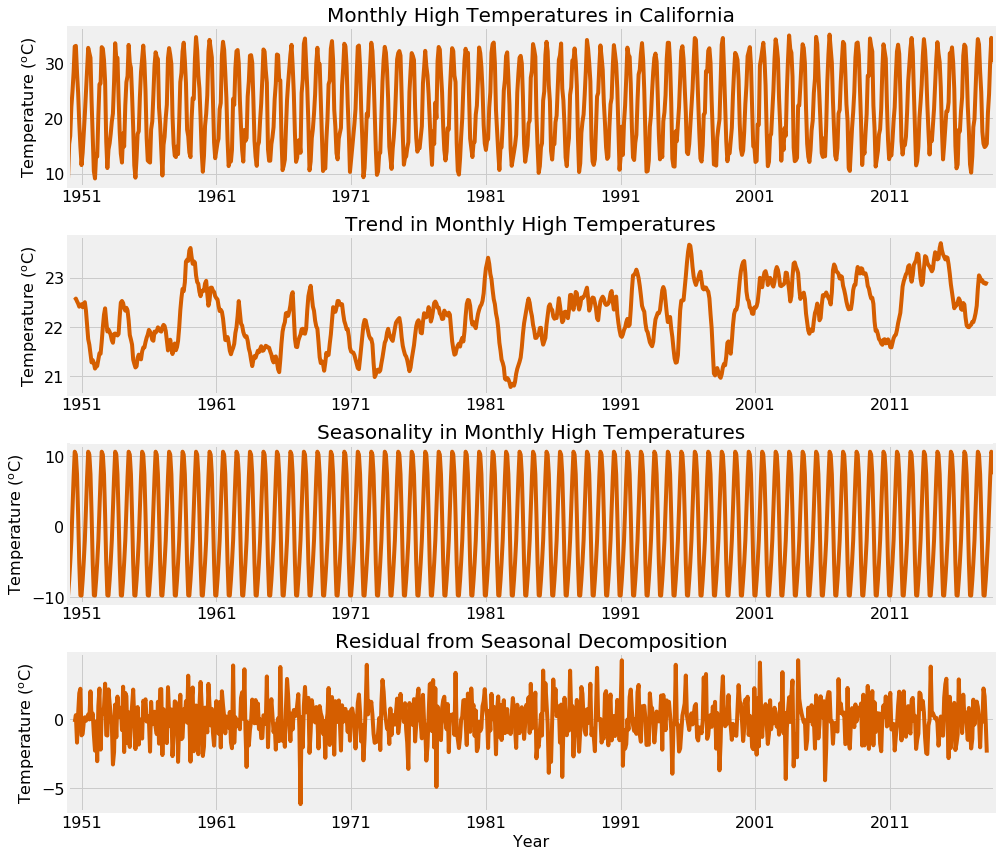

In [38]:
rcParams['figure.figsize'] = 18, 8
decomposition_high = seasonal_decompose(combined_high_temperature_ts, freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(combined_high_temperature_ts, color = [213/255,94/255,0])
ax1.set_title('Monthly High Temperatures in California', fontsize = 20)
ax2.plot(decomposition_high.trend, color = [213/255,94/255,0])
ax2.set_title('Trend in Monthly High Temperatures', fontsize = 20)
ax3.plot(decomposition_high.seasonal, color = [213/255,94/255,0])
ax3.set_title('Seasonality in Monthly High Temperatures', fontsize = 20)
ax4.plot(decomposition_high.resid, color = [213/255,94/255,0])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 1950, month = 1, day = 1), 
              datetime.datetime(year = 2018, month = 9, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

There appears to be a slight increase in high temperatures in the summers of 2017 and 2018 in California. From 1950 to 2018, however, we see that there has been an increase in the high temperatures by about one degree Celsius in California. 

We should also note how the time series shows that California had a warm winter in 2017.

Let us fit a SARIMA model to this time series. 

In [39]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

min_aic = 1e8

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(combined_high_temperature_ts,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < min_aic:
                min_aic = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7541.406374840788
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6484.436731285365
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:5709.280680364696
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3669.3826747671674
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3101.1951923203924
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:3057.5810738643045
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:3052.457003539876
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:3036.17777067296
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:3031.039677234545
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:3030.5211552143055
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:3025.999643513992
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:3022.1014895647168
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:3020.3783528956483


In [39]:
model_high = SARIMAX(combined_high_temperature_ts,
                     order=(1, 1, 2),
                     seasonal_order=(1, 1, 2, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

results_high = model_high.fit()

print(results_high.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                monthly_temperature   No. Observations:                  825
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1503.189
Date:                            Thu, 08 Nov 2018   AIC                           3020.378
Time:                                    01:46:31   BIC                           3053.038
Sample:                                01-01-1950   HQIC                          3032.936
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4100      0.188      2.185      0.029       0.042       0.778
ma.L1         -1.2549      0.198   

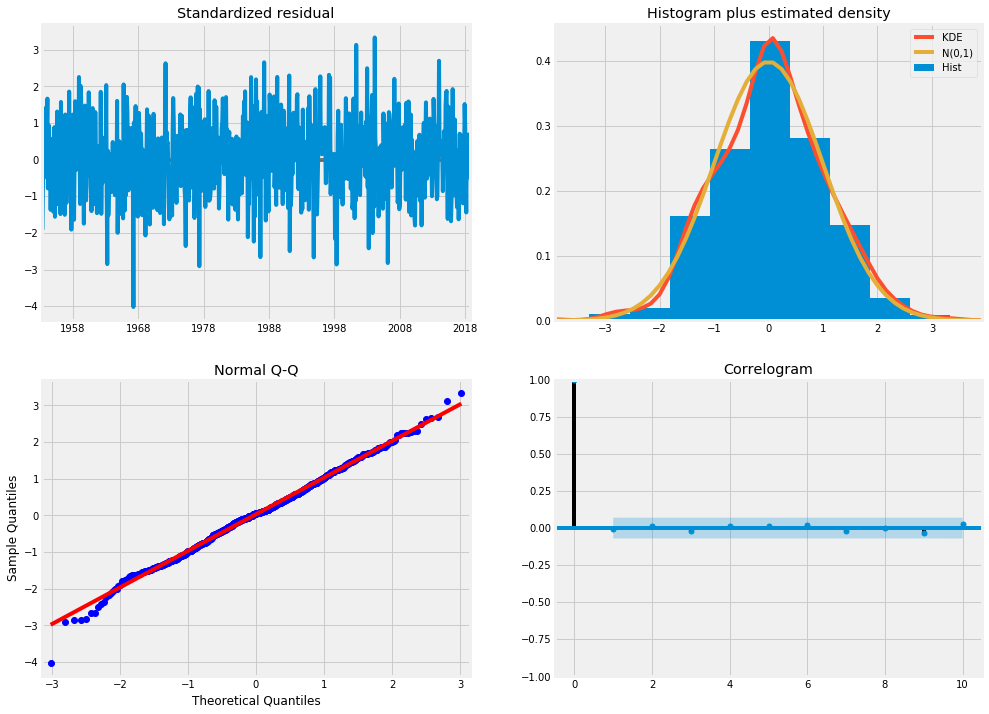

In [40]:
results_high.plot_diagnostics(figsize=(15, 12))
plt.show()

We have determined the functional form of our SARIMA model that we fit to our high temperature time series. The residuals are normally distributed and uncorrelated. Most of the coefficients are statistically significant.

Let us see how the model reproducees the high monthly temperatures in California from 2013 to 2018 and predicts the high temperatures beyond 2018.

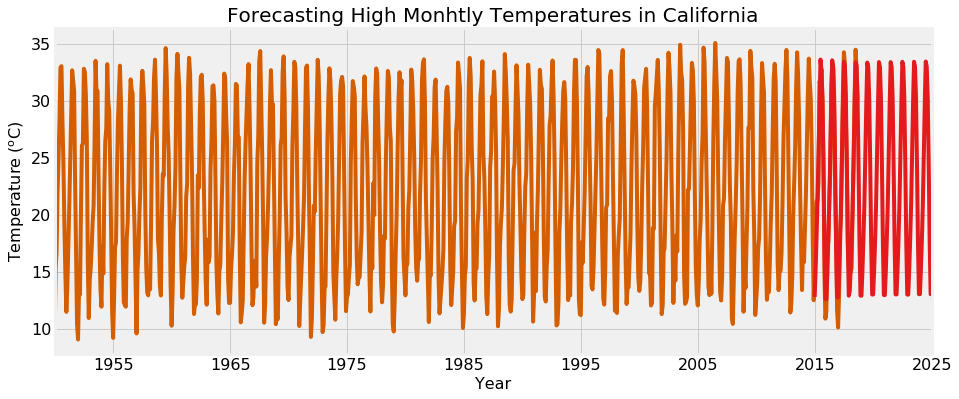

In [41]:
fig = plt.figure(figsize = (14, 6))
plt.plot(combined_high_temperature_ts, color = [213/255,94/255,0])
plt.title('Forecasting High Monhtly Temperatures in California', fontsize = 20)
plt.plot(results_high.predict(start = 780, end = 900, dynamics = True), color = [228/255,26/255,28/255])
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xlim([datetime.datetime(year = 1950, month = 1, day = 1),
          datetime.datetime(year = 2025, month = 1, day = 1)]);

The predicted temperatures beyond 2018 seem to have a rather constant average. Let us perform seasonal decomposition on the predicted temperatures from 2018 to 2025.

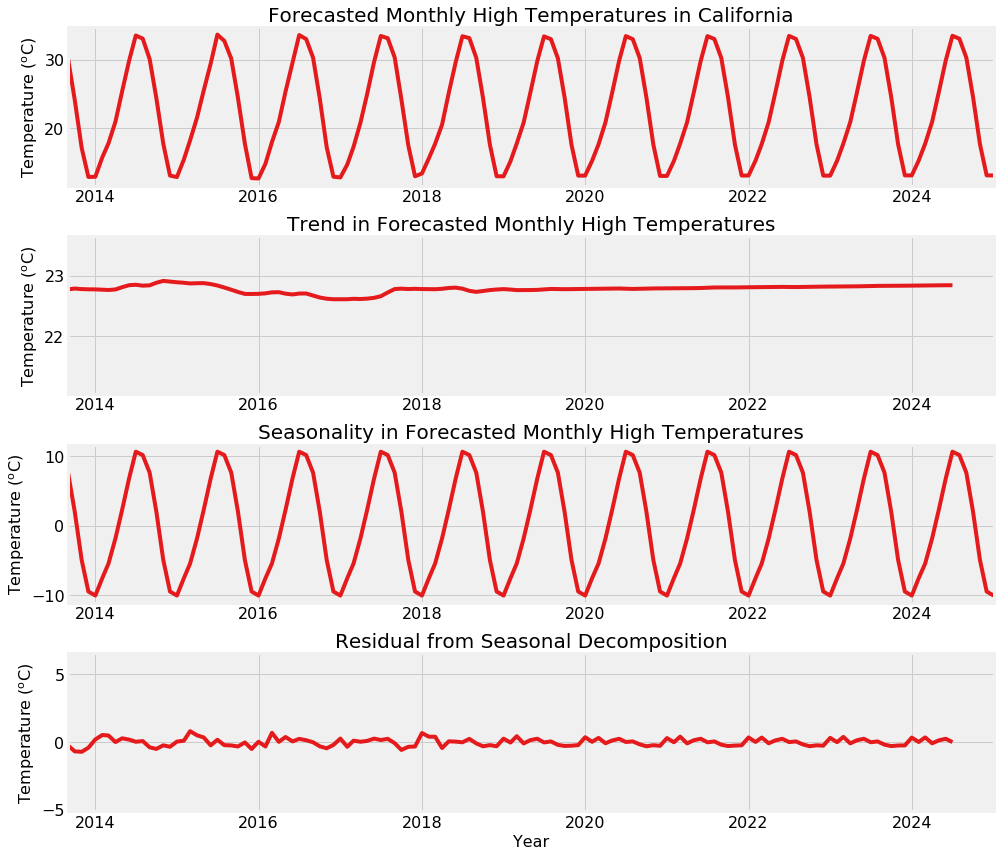

In [42]:
rcParams['figure.figsize'] = 18, 8
decomposition_high = seasonal_decompose(results_high.predict(start = 0, end = 900, dynamics = True), freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(results_high.predict(start = 763, end = 900, dynamics = True), color = [228/255,26/255,28/255])
ax1.set_title('Forecasted Monthly High Temperatures in California', fontsize = 20)
ax2.plot(decomposition_high.trend, color = [228/255,26/255,28/255])
ax2.set_title('Trend in Forecasted Monthly High Temperatures', fontsize = 20)
ax3.plot(decomposition_high.seasonal, color = [228/255,26/255,28/255])
ax3.set_title('Seasonality in Forecasted Monthly High Temperatures', fontsize = 20)
ax4.plot(decomposition_high.resid, color = [228/255,26/255,28/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 2013, month = 9, day = 1), 
              datetime.datetime(year = 2025, month = 1, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

Do our predictions imply that the reported high temperatures in California after 2018 will remain constant? Maybe that is what we should hope for, considering how warm the summers have gotten recently in California. That said, it will be interesting if additional temperature measurements change the predictions, or if quality changes to the recent temperature measurements also change the predictions. We should not be surprised if we continue to have record-breaking temperatures in future summers in California, despite our predictions in this project.

Now let's look at the low temperatures.

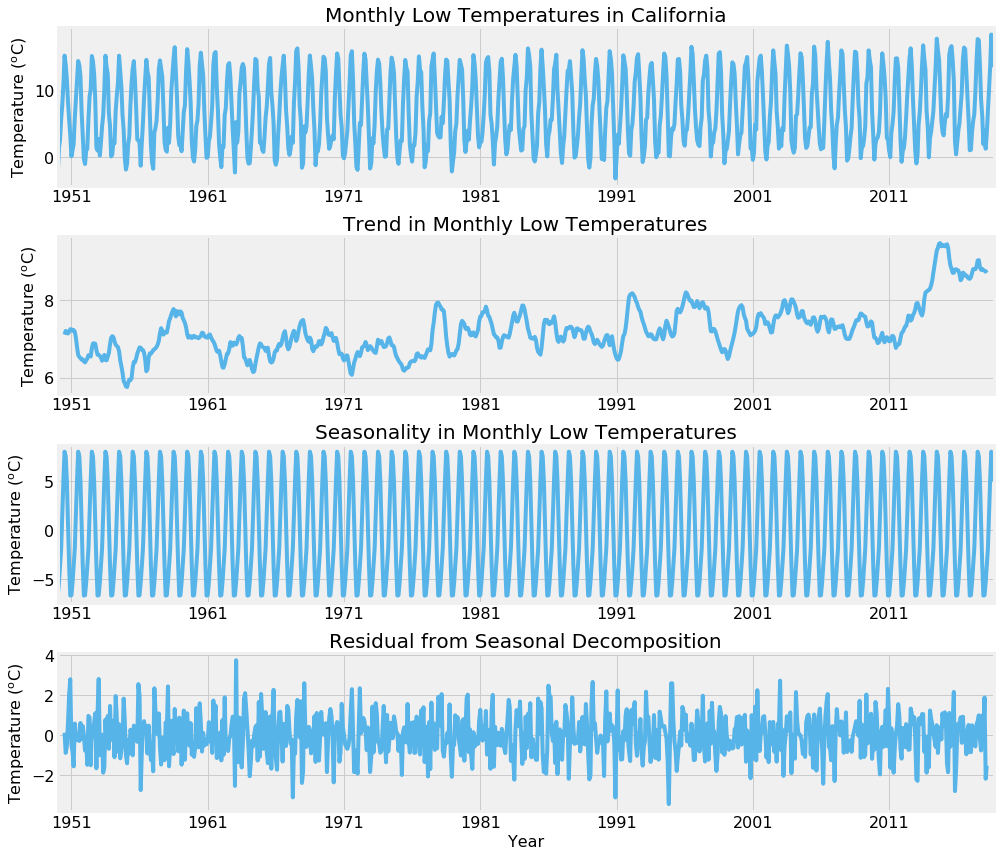

In [43]:
rcParams['figure.figsize'] = 18, 8
decomposition_low = seasonal_decompose(combined_low_temperature_ts, freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(combined_low_temperature_ts, color = [86/255,180/255,233/255])
ax1.set_title('Monthly Low Temperatures in California', fontsize = 20)
ax2.plot(decomposition_low.trend, color = [86/255,180/255,233/255])
ax2.set_title('Trend in Monthly Low Temperatures', fontsize = 20)
ax3.plot(decomposition_low.seasonal, color = [86/255,180/255,233/255])
ax3.set_title('Seasonality in Monthly Low Temperatures', fontsize = 20)
ax4.plot(decomposition_low.resid, color = [86/255,180/255,233/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 1950, month = 1, day = 1), 
              datetime.datetime(year = 2018, month = 9, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

While we did not observe dramatic changes in the high monthly tempearatures in California from 2013 to 2018, we see an increase by at least one degree Celsius in the low monthly temperatures. This would correspond to, for example, warmer nights. Let us analyze this time series.

In [49]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

min_aic = 1e8

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(combined_low_temperature_ts,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < min_aic:
                min_aic = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5959.843087033732
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5024.815827369629
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:4425.073644739744
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3071.773181428453
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2603.2535313773287
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:2565.8674990132995
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:2564.5447635491064
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2560.457712877505
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:2521.960994951818
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:2519.5886174621273
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:2514.9217436175904
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:2512.9547375846173
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:2499.320389190147
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:2498.472023310569
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:2479.8848197540656
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:2478.3476185617164


We only need to fit a linear SARIMA equation to the seasonal difference of the low temperature time series.

In [44]:
model_low = SARIMAX(combined_low_temperature_ts,
                    order=(0, 1, 2),
                    seasonal_order=(1, 1, 2, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)

results_low = model_low.fit()

print(results_low.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                monthly_temperature   No. Observations:                  825
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1233.174
Date:                            Thu, 08 Nov 2018   AIC                           2478.348
Time:                                    01:48:17   BIC                           2506.342
Sample:                                01-01-1950   HQIC                          2489.111
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8851      0.043    -20.676      0.000      -0.969      -0.801
ma.L2         -0.1707      0.038   

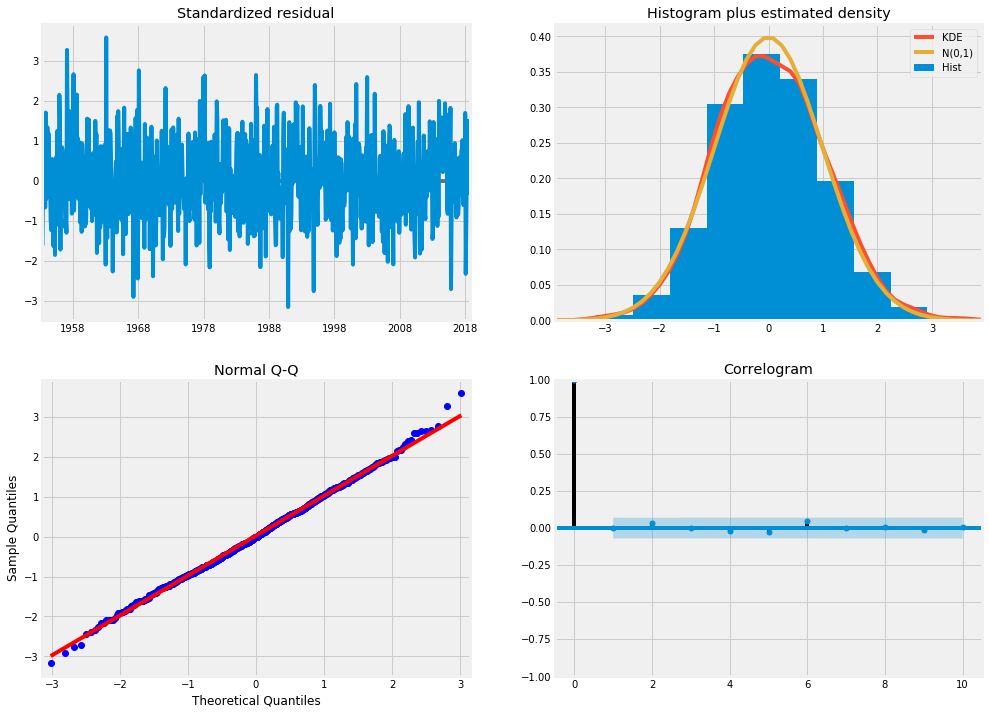

In [45]:
results_low.plot_diagnostics(figsize=(15, 12))
plt.show()

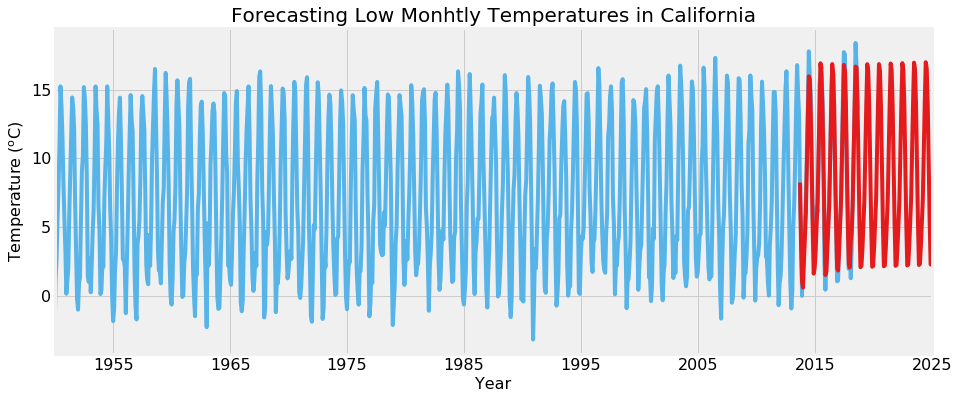

In [46]:
fig = plt.figure(figsize = (14, 6))
plt.plot(combined_low_temperature_ts, color = [86/255,180/255,233/255])
plt.title('Forecasting Low Monhtly Temperatures in California', fontsize = 20)
plt.plot(results_low.predict(start = 765, end = 900, dynamics = True), color = [228/255,26/255,28/255])
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16)
plt.tick_params(labelsize = 16)
plt.xlim([datetime.datetime(year = 1950, month = 1, day = 1),
          datetime.datetime(year = 2025, month = 1, day = 1)]);

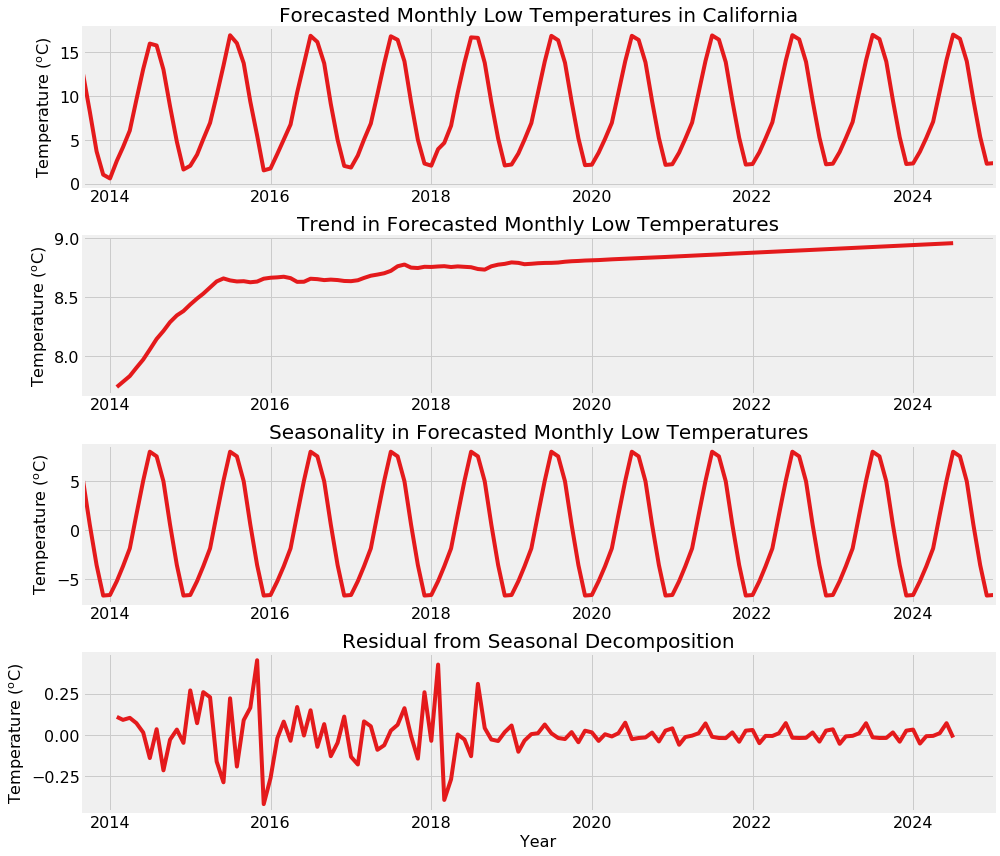

In [47]:
rcParams['figure.figsize'] = 18, 8
decomposition_low = seasonal_decompose(results_low.predict(start = 763, end = 900, dynamics = True), freq = 12)

fig = plt.figure(figsize = (14,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(results_low.predict(start = 763, end = 900, dynamics = True), color = [228/255,26/255,28/255])
ax1.set_title('Forecasted Monthly Low Temperatures in California', fontsize = 20)
ax2.plot(decomposition_low.trend, color = [228/255,26/255,28/255])
ax2.set_title('Trend in Forecasted Monthly Low Temperatures', fontsize = 20)
ax3.plot(decomposition_low.seasonal, color = [228/255,26/255,28/255])
ax3.set_title('Seasonality in Forecasted Monthly Low Temperatures', fontsize = 20)
ax4.plot(decomposition_low.resid, color = [228/255,26/255,28/255])
ax4.set_title('Residual from Seasonal Decomposition', fontsize = 20)

[ax.set_xlim([datetime.datetime(year = 2013, month = 9, day = 1), 
              datetime.datetime(year = 2025, month = 1, day = 1)]) for ax in [ax1, ax2, ax3, ax4]]

[ax.tick_params(labelsize = 16) for ax in [ax1, ax2, ax3, ax4]]
[ax.set_ylabel('Temperature ($^\mathrm{o}$C)', fontsize = 16) for ax in [ax1, ax2, ax3, ax4]]
ax4.set_xlabel('Year', fontsize = 16)

fig.tight_layout()

Our predictions tell us that the monthly low temperatures in California will be increasing by about 0.2 degree Celsius from 2018 to 2025. Once again, we should state that this prediction is likely to change, and that predictions for the far future are very likely to be incorrect.

# Conclusion
From our analysis of time series of monthly temperatures in California, we do see the gradual increase in temperature (up to roughly one degree Celsius) in the average, high, and low temperatures. We also see noticeable changes in the temperature in the past five years. Our predictions tell us that the average and low temperatures will continue to rise. While our predictions tell us the high temperatures may remain relatively constant, we should not be surprised if we continue to see headlines talking about "record-breaking temperatures" in California in the future.

This has been an exploration of temperature data in California. We note, however, that we have only looked at statewide temperature values, averaged over the entirety of California. California is a large state with a huge variety in climates (northern California versus southern California, coast versus inland, Sierra Nevada versus deserts, ...). 

What we can also obtain from the Berkeley Earth datasets are temperature readings for specific latitudes and longitudes in California over the past ~200 years. We can use this gridded data together with our database of wildfires in the United States to possibly explore the relationship between the temperature and the degree of devastation of wildfires.